In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import csv
import subprocess
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
from cot.data import BinaryCopy, Parity
from cot.config import CHECK_DIR
from cot.models import TransformerConfig, Transformer

WIDTH = 5.5            # inches (from ICML style file)
HEIGHT = 5.5 / 1.5     # golden ratio


# rc('font', family='serif', size=8)
# usetex = not subprocess.run(['which', 'pdflatex']).returncode
# rc('text', usetex=usetex)
# if usetex:
#     rc('text.latex', preamble=r'\usepackage{times}')

Looking at the evaluation metrics

In [33]:
check_dir = CHECK_DIR / 'parity'
checkpoint = torch.load(check_dir / 'model.pth', map_location='cpu')

filename = check_dir / "eval.csv"
with open(filename, 'r') as f:
    reader = csv.reader(f, delimiter=',')
    meaning = next(reader)
    data = list(reader)
evals = np.array(data, dtype=float)


In [34]:
timestamps = evals[:, 0]
eval_dim = (evals.shape[1] - 1) // 2
train_evals = evals[:, 1 : 1 + eval_dim]
test_evals = evals[:, 1 + eval_dim:]

In [35]:
np_meaning = np.array([stri[:-6] for stri in meaning[1: 1 + eval_dim]])

min_len = 8
n_len = 16
res = np.zeros((2, n_len - min_len), dtype=float)
for i, eval_prefix in enumerate(['attn0_peaky_thres', 'attn1_peaky_thres']):
    for j, length in enumerate(range(min_len, n_len)):
        eval_name = f"{eval_prefix}_{length}"

        ind = np.argmax(np_meaning == eval_name)
        assert ind != 0

        train_res = train_evals[-1, ind]
        test_res = test_evals[-1, ind]
        res[i, j] = test_res
res = res.mean(axis=0)

In [36]:
print(res)

[0.32611084 0.45838759 0.37543945 0.32253196 0.31490072 0.15598708
 0.39526367 0.24625651]


Looking at the model attention maps

In [19]:
token_emb = checkpoint['model_state_dict']['embeddings.token_emb.weight'].cpu()
pos_emb = checkpoint['model_state_dict']['embeddings.pos_emb.weight'].cpu()

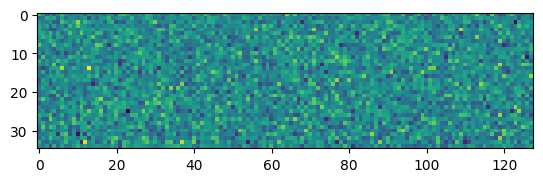

In [29]:
plt.imshow(pos_emb)

In [20]:
lengths = list(np.arange(n_len) + 1)

problem = 'parity'
if problem == 'binary-copy':
    testset = BinaryCopy()
elif problem == 'parity':
    testset = Parity()
testset.set_data(lengths, data_type="test")

In [21]:
config = TransformerConfig(
    vocab_size=torch.max(testset.data).item() + 1,
    emb_dim=128,
    pos_emb=True,
    seq_len=len(testset[0]),
    emb_dropout=0,
    n_head=1,
    n_layer=2,
)

model = Transformer(config)
model.load_state_dict(checkpoint["model_state_dict"])
# model.to(device=device)
model.eval()

i = -4000
sequence = testset.data[i:i + 1]
# sequence = sequence.to(device=device, dtype=torch.long)

with torch.no_grad():
    logits, attentions = model(sequence, verbose=True)
attn0 = attentions[0, 0, 0].cpu()
attn1 = attentions[1, 0, 0].cpu()

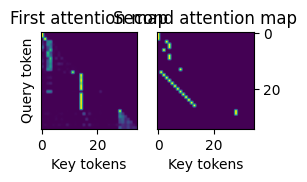

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(.5 * WIDTH, .5 * HEIGHT))
axes[0].imshow(attn0)
axes[1].imshow(attn1 > .5)
axes[0].set_title('First attention map')
axes[1].set_title('Second attention map')
axes[0].set_xlabel('Key tokens')
axes[1].set_xlabel('Key tokens')
axes[0].set_ylabel('Query token')
axes[0].set_yticks([])
axes[1].yaxis.tick_right()
fig.savefig('attention_map.pdf', bbox_inches="tight")

Let us now focus on some training dynamics curve.

In [23]:
check_dir = CHECK_DIR / '590d57e0-c357-450b-a16e-1b5ef14bd1ba'
checkpoint = torch.load(check_dir / 'model.pth', map_location='cpu')

timestamps = checkpoint['timestamps']
ind = timestamps != -1
timestamps = timestamps[ind]

meaning = checkpoint['meaning']
evals = checkpoint['evals'][ind]

eval_dim = evals.shape[1] // 2
train_evals = evals[:, :eval_dim]
test_evals = evals[:, eval_dim:]

FileNotFoundError: [Errno 2] No such file or directory: '/checkpoint/vivc/models/590d57e0-c357-450b-a16e-1b5ef14bd1ba/model.pth'

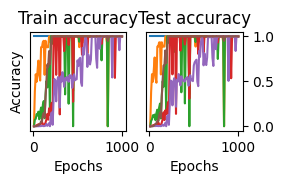

In [38]:
i = 200
fig, axes = plt.subplots(1, 2, figsize=(.5 * WIDTH, .35 * HEIGHT))
axes[0].plot(timestamps[:i], train_evals[:i, :n_len:3])
axes[1].plot(timestamps[:i], test_evals[:i, :n_len:3])
axes[0].set_title('Train accuracy')
axes[1].set_title('Test accuracy')
axes[0].set_xlabel('Epochs')
axes[1].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks([])
axes[1].yaxis.tick_right()
fig.savefig('evals.pdf', bbox_inches="tight")

In [ ]:
sequence

tensor([[59,  1,  0,  1,  1,  1,  1,  1,  0,  0,  1,  0,  0,  0,  1,  0, 62,  1,
          1,  0,  1,  0,  1,  0,  0,  0,  1,  1,  1,  1,  0,  0, 63, 63, 63]],
       dtype=torch.int32)